### ***Importing Necessary Libraries***

In [66]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

### ***Loading Dataset***

In [67]:
df = pd.read_csv("Datasets/AAPL.csv")

In [68]:
df.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume
9821,2019-11-22,262.589996,263.179993,260.839996,261.779999,261.779999,16331300.0
9822,2019-11-25,262.709991,266.440002,262.519989,266.369995,266.369995,21005100.0


### ***Data Preprocessing***

> #### ***1. Time-Series Conversion***

In [69]:
df = df.set_index(df['Date'])

In [70]:
df.drop(columns=["Date"], inplace=True)

In [71]:
df.index = pd.to_datetime(df.index)

In [72]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0


> #### ***2. Feature Engineering - Day_Gap Column***

In [73]:
df['Date'] = df.index
df['Day Gap'] = (df['Date'] - df['Date'].shift(1)).dt.days.fillna(1).astype(float)
df.drop(columns=['Date'], inplace=True)

In [74]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume,Day Gap
Date,,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0,1.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0,3.0


> #### ***3. Handling Null Values***

In [75]:
df[df.isnull().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume,Day Gap
Date,,,,,,,
1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [76]:
df = df.interpolate(method="time")

In [77]:
df.iloc[164:167]

,Open,High,Low,Close,Adj Close,Volume,Day Gap
Date,,,,,,,
1981-08-07,0.450893,0.453125,0.450893,0.450893,0.358108,2301600.0,1.0
1981-08-10,0.444196,0.444754,0.440848,0.440848,0.350130,13973400.0,3.0
1981-08-11,0.441964,0.441964,0.437500,0.437500,0.347471,17864000.0,1.0


> ### ***4. Dataset Split***

In [78]:
train = df[df.index.year <= 2016]
test = df[df.index.year >= 2017]

In [79]:
print(f"train : {train.shape} - {(train.shape[0]/df.shape[0])*100:.2f} %")
print(f"test : {test.shape} - {(test.shape[0]/df.shape[0])*100:.2f} %")

train : (9093, 7) - 92.57 %
test : (730, 7) - 7.43 %


> ### ***5. Feature Selection***

In [80]:
target_col  = 'Adj Close'
feature_col = ['Open', 'High', 'Low', 'Close', 'Volume', 'Day Gap']

In [81]:
X_train, y_train = train[feature_col], train[target_col]
X_test, y_test   = test[feature_col], test[target_col]

In [82]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9093, 6) (9093,)
(730, 6) (730,)


> ### ***5. Scaling***
> > *Min-Max Scalar*

In [83]:
# Load Min-Max Scalar

feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

In [84]:
X_train_scaled = feature_scaler.fit_transform(train[feature_col])
y_train_scaled = target_scaler.fit_transform(train[[target_col]])

X_test_scaled = feature_scaler.transform(test[feature_col])
y_test_scaled = target_scaler.transform(test[[target_col]])

## ***Model Building***

> ### ***1. Creating Sequential Input/Output Data***

In [85]:
# Preparing 50-days rolling window (input) and 5-day forecasting horizon (output)

def create_multi_horizon_sequences(features, target, lookback=50, horizons=[1, 5, 10]):
    X_seq, y_seq = [], []
    max_horizon = max(horizons)

    for i in range(len(features) - lookback - max_horizon + 1):
        X_seq.append(features[i:i+lookback])
        y_seq.append([target[i+lookback+h-1] for h in horizons])
    
    return np.array(X_seq), np.array(y_seq)

In [86]:
lookback = 50
horizons = [1, 5, 10]

X_train_seq, y_train_seq = create_multi_horizon_sequences(X_train_scaled, y_train_scaled, lookback, horizons)
X_test_seq, y_test_seq   = create_multi_horizon_sequences(X_test_scaled, y_test_scaled, lookback, horizons)

In [87]:
print("Before reshape:")
print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("y_test_seq:", y_test_seq.shape)

Before reshape:
X_train_seq: (9034, 50, 6)
y_train_seq: (9034, 3, 1)
X_test_seq: (671, 50, 6)
y_test_seq: (671, 3, 1)


In [88]:
input_shape = (lookback, len(feature_col))
input_shape

(50, 6)

In [89]:
# Reshaping for RNN input

y_train_seq = y_train_seq.reshape(y_train_seq.shape[0], y_train_seq.shape[1])
y_test_seq = y_test_seq.reshape(y_test_seq.shape[0], y_test_seq.shape[1])

In [90]:
print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Test:", X_test_seq.shape, y_test_seq.shape)

Train: (9034, 50, 6) (9034, 3)
Test: (671, 50, 6) (671, 3)


In [91]:
# Ensure y is 2D
if y_train_seq.ndim == 2:
    #y_train_seq = y_train_seq.reshape(-1, 1)
    print(y_train_seq.shape)

(9034, 3)


> ### ***2. Simple RNN***

In [92]:
# Building and Compiling RNN layers

def build_rnn(rnn_type='SimpleRNN', rnn_units=64, dropout_rate=0.2, learning_rate=0.001, input_shape=None):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(rnn_units, activation="tanh"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train_seq.shape[1]))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [96]:
early_stop = EarlyStopping(monitor='loss', 
                           patience=3, 
                           restore_best_weights=True,
                           verbose=1)

checkpoint = ModelCheckpoint(filepath="models/SimpleRNN_best_model_90_percent_train.keras",
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='loss') 

In [97]:
# Wrapping the model

rnn_regressor = KerasRegressor(model=build_rnn, 
                               epochs=30, 
                               batch_size=32,
                               verbose=0,
                               callbacks=[early_stop, checkpoint])

> ### ***3. Hyperparameter Tuning with GridSearchCV***

In [98]:
# Defining Parameters

param_grid = {'model__rnn_units': [32, 64],
              'model__dropout_rate': [0.1, 0.2],
              'model__learning_rate': [0.001, 0.01],
              'model__input_shape': [(X_train_seq.shape[1], X_train_seq.shape[2])]}

In [99]:
grid = GridSearchCV(rnn_regressor, 
                    param_grid, 
                    cv=3, 
                    n_jobs=-1,
                    verbose=2)

##  **Model Training**

> ### ***Saving Best SimmpleRNN Model***

In [100]:
best_rnn = grid.fit(X_train_seq, y_train_seq)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 17.


In [101]:
best_rnn

,estimator,KerasRegresso...e epochs=30 )
,param_grid,"{'model__dropout_rate': [0.1, 0.2], 'model__input_shape': [(50, ...)], 'model__learning_rate': [0.001, 0.01], 'model__rnn_units': [32, 64]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...0023182747240>


In [102]:
best_model = grid.best_estimator_
best_model

,model,<function bui...0023182747240>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,32
,validation_batch_size,None
,verbose,0
,callbacks,"[<keras.src.ca...002318A975490>, <keras.src.ca...002318B428CD0>]"


In [103]:
best_params = grid.best_params_
print(best_params)

{'model__dropout_rate': 0.1, 'model__input_shape': (50, 6), 'model__learning_rate': 0.001, 'model__rnn_units': 64}


In [104]:
best_score = grid.best_score_
print(best_score)

0.8437180403969297


In [105]:
cv_results = grid.cv_results_
print(cv_results.keys())  # Lists all metrics available

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__dropout_rate', 'param_model__input_shape', 'param_model__learning_rate', 'param_model__rnn_units', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


## ***Model Evaluation***

In [106]:
# Predicting Scaled Y_test data
y_pred_scaled = best_model.predict(X_test_seq)

In [107]:
# Unscaling the predicted values
y_pred = target_scaler.inverse_transform(y_pred_scaled) 
y_true = target_scaler.inverse_transform(y_test_seq)

In [108]:
for i, h in enumerate(horizons):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"Horizon t+{h}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

Horizon t+1: MSE=48.6243, RMSE=6.9731, MAE=6.0603
Horizon t+5: MSE=132.4483, RMSE=11.5086, MAE=9.7913
Horizon t+10: MSE=215.9113, RMSE=14.6939, MAE=12.2385


## ***SimpleRNN Prediction Plot***

In [109]:
# Getting dates for test data
y_dates = test.index[lookback + max(horizons) - 1:]
print(len(y_dates), y_test_orig.shape[0])

671 2181


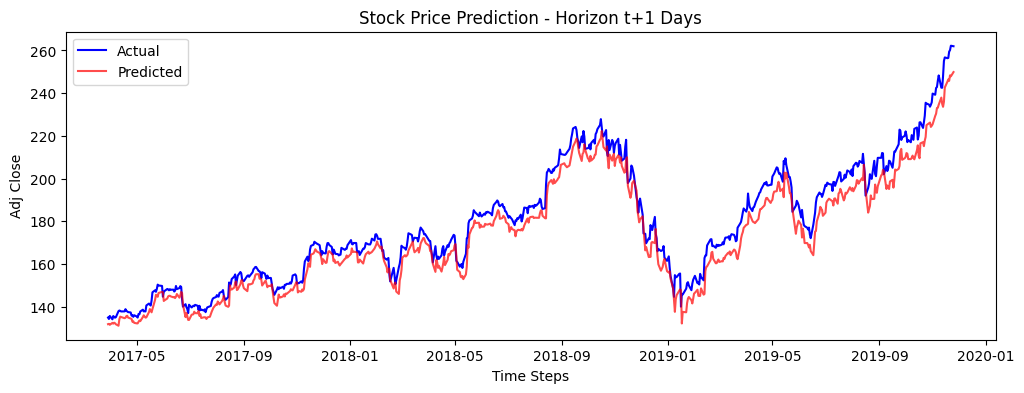

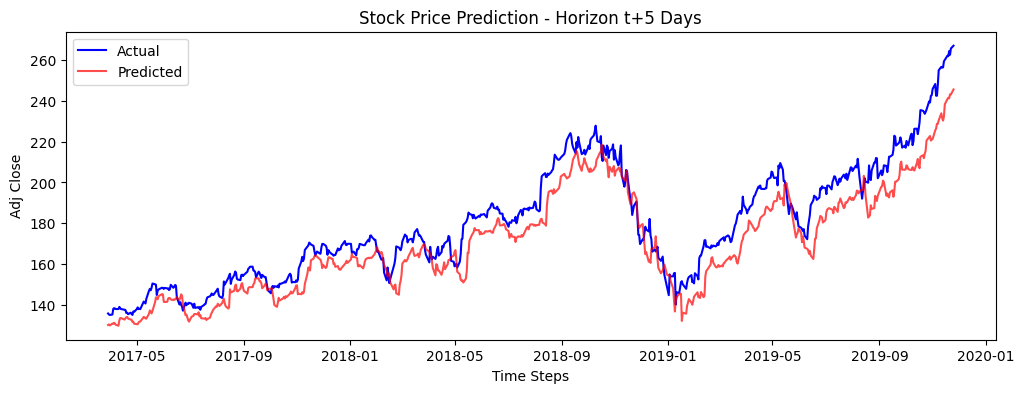

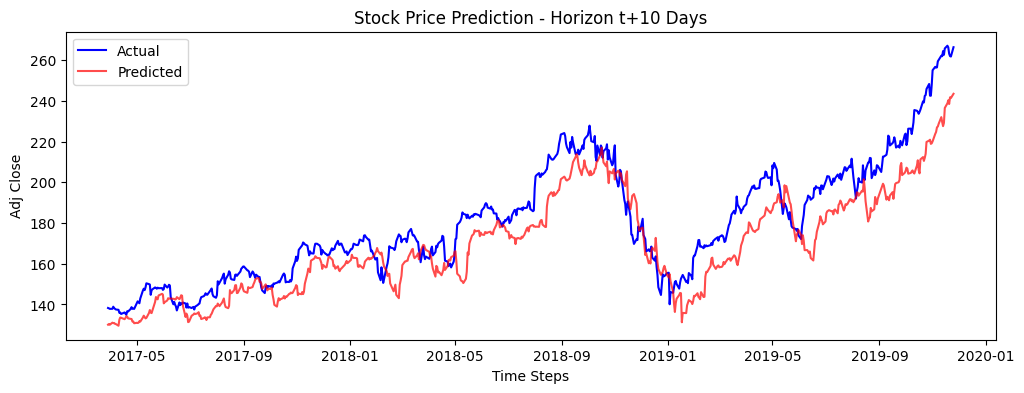

In [111]:
for i, h in enumerate(horizons):
    plt.figure(figsize=(12, 4))
    plt.plot(y_dates, y_true[:, i], label='Actual', color='blue')
    plt.plot(y_dates, y_pred[:, i], label='Predicted', color='red', alpha=0.7)
    plt.title(f'Stock Price Prediction - Horizon t+{h} Days')
    plt.xlabel('Time Steps')
    plt.ylabel('Adj Close')
    plt.legend()
    plt.show()